In [1]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import math
import sys
sys.path.insert(0, './code')
from CastCol import cast_columns

gzip = True
if gzip:
    import gzip
    open = gzip.open

In [2]:
def ip_to_user(ip, group_size=5, starting=5):
    isp = int(int(ip.split(".")[-2]))
    node_number = int(ip.split(".")[-1]) - starting - isp
    user = node_number % group_size
    group = math.floor(node_number / group_size)
    return '/tordata/config/group_' + str(group) + "_user_" + str(user)

In [3]:
def limit_range(ts1, ts2):
    range = min(ts2.index.values), max(ts2.index.values)
    ts1 = ts1.loc[(ts1.index >= range[0]) & (ts1.index <= range[1])]
    return ts1

In [4]:
def load(data_file):
    with open(data_file, 'rb') as file:
        traffic = pickle.load(file)
        msgs = pickle.load(file)
    return traffic, msgs

def select(data, ip, feature, limit=False):
    traffic = data[0][ip][feature]
    msgs = data[1][ip_to_user(ip)]["count"]
    if limit:
        traffic = limit_range(traffic, msgs)
    return traffic, msgs

def plot(ts,):
    fig, ax = plt.subplots(figsize=(8, 6))
    for t in ts:
        ax.plot(t[0], label=t[1])
    plt.legend()

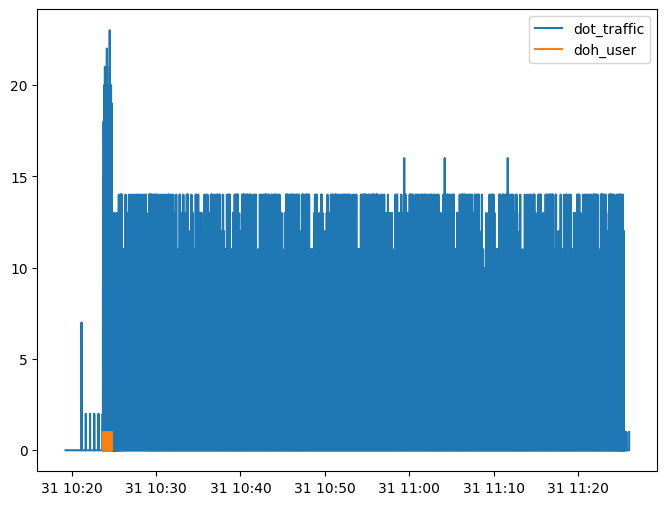

In [9]:
data_file = "code/pkl/dot_all_scopes_https_multiISP_vpn_all_ts.pkl.gz"
ip = "102.0.10.56"
feature = "count_ISPAll"

dot = load(data_file)
dot_traffic, dot_user = select(dot, ip, feature, limit=False)
plot([(dot_traffic, "dot_traffic"), (dot_user, "doh_user")])

In [7]:
data_file = "code/pkl/doh_all_scopes_https_multiISP_vpn_ts.pkl"
ip = "102.0.10.56"

doh = load(data_file)
doh_traffic, doh_user = select(doh, ip, feature, limit=False)
plot([(doh_traffic, "doh_traffic"), (doh_user, "doh_user")])

FileNotFoundError: [Errno 2] No such file or directory: 'code/pkl/doh_all_scopes_https_multiISP_vpn_ts.pkl'

In [7]:
def set_time_zero(df):
    start_time = df.index.min()
    df.index = (df.index - start_time)
    return df

def norm(df):
    max_values = df.max()
    df = df / max_values
    return df

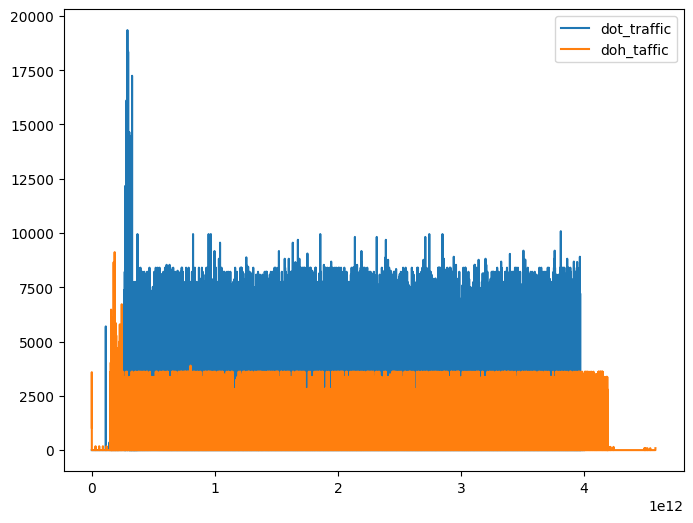

In [8]:
plot([(set_time_zero(dot_traffic), "dot_traffic"), (set_time_zero(doh_traffic), "doh_taffic")])

In [9]:
import numpy as np

def plot_dist(series, name, ignore_zero=False):
    time_duration = series.index[-1] - series.index[0]
    num_zeros = (series == 0).sum()
    total_sum = series.sum()
    if ignore_zero:
        series = series[series != 0]
    plt.figure(figsize=(8, 6))  # Create a new figure
    plt.hist(series, bins=50)  # Adjust the number of bins as needed
    plt.title(f'Distribution of {name}')
    plt.xlabel(series.name)
    plt.ylabel('Frequency')

    # Calculate mean and standard deviation
    mean_value = np.mean(series)
    std_value = np.std(series)
    
    # Add labels for mean and standard deviation
    plt.text(0.7, 0.8, f'Mean: {mean_value:.2f}', transform=plt.gca().transAxes)
    plt.text(0.7, 0.7, f'Std: {std_value:.2f}', transform=plt.gca().transAxes)
    plt.text(0.7, 0.6, f'Zeros: {num_zeros}', transform=plt.gca().transAxes)
    plt.text(0.7, 0.5, f'Sum: {total_sum:.2f}', transform=plt.gca().transAxes)
    plt.text(0.7, 0.4, f'Time Duration: {time_duration}', transform=plt.gca().transAxes)

    plt.grid(True)
    plt.show()

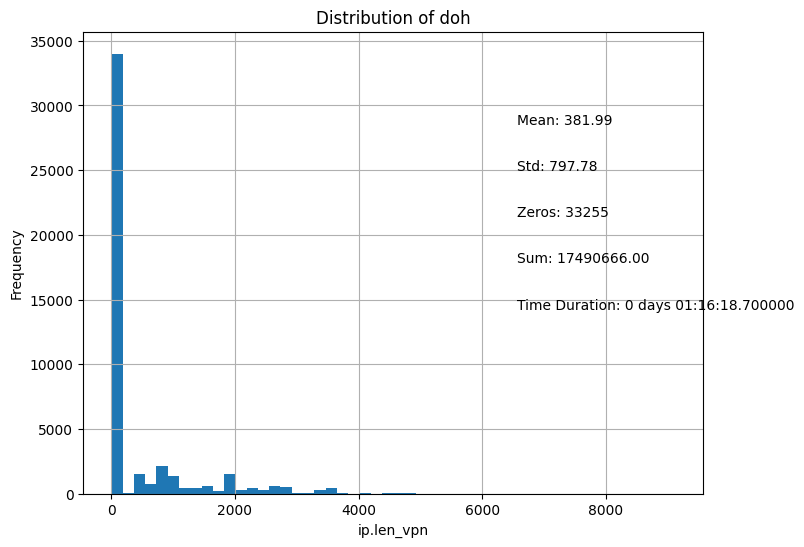

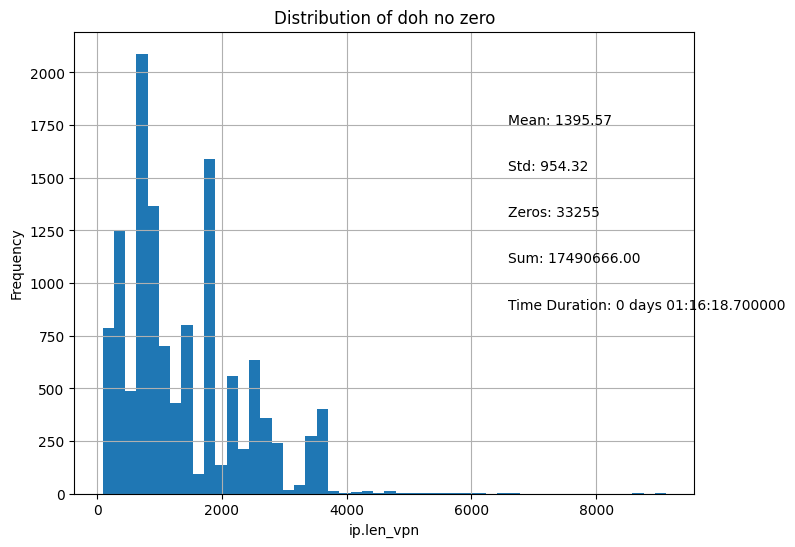

In [10]:
plot_dist(doh_traffic, "doh")
plot_dist(doh_traffic, "doh no zero", ignore_zero=True)

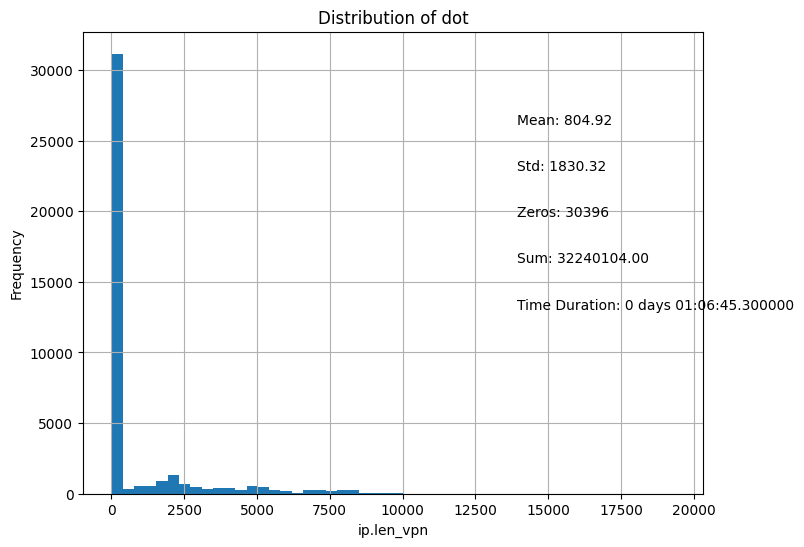

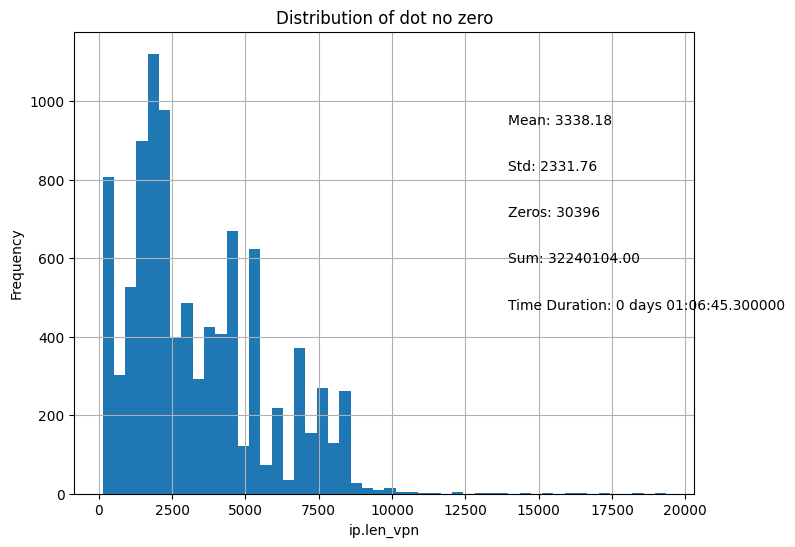

In [11]:
plot_dist(dot_traffic, "dot")
plot_dist(dot_traffic, "dot no zero", ignore_zero=True)

In [12]:
def stats(data):
    time_duration = []
    num_zeros = []
    total_sum = []
    mean_value = []
    std_value = []
    for series in data:
        time_duration += [(series.index[-1] - series.index[0]).total_seconds()]
        num_zeros += [(series == 0).sum()]
        total_sum += [series.sum()]
        mean_value += [np.mean(series)]
        std_value += [np.std(series)]
    return {"Duration": [np.mean(time_duration), np.std(time_duration)], 
            "number of zeros": [np.mean(num_zeros), np.std(num_zeros)], 
            "Sum ": [np.mean(total_sum), np.std(total_sum)], 
            "mean": [np.mean(mean_value), np.std(mean_value)], 
            "std": [np.mean(std_value), np.std(std_value)]}

In [13]:
for ip in dot[0]:
    cast_columns(dot[0][ip])
for user in dot[1]:
    cast_columns(dot[1][user])
dot_stats_all = [select(dot, ip, feature) for ip in dot[0]]
dot_stats_overlap = [select(dot, ip, feature, limit=True) for ip in dot[0]]

for ip in doh[0]:
    cast_columns(doh[0][ip])
for user in doh[1]:
    cast_columns(doh[1][user])
doh_stats_all = [select(doh, ip, feature) for ip in doh[0]]
doh_stats_overlap = [select(doh, ip, feature, limit=True) for ip in doh[0]]

In [14]:
d = stats([ip[0] for ip in dot_stats_all])
pd.DataFrame(d, index=["mean", "std"])

,Duration,number of zeros,Sum,mean,std
mean,4081.68500,30483.480000,3.177275e+07,778.607666,1713.575960
std,72.36709,804.474741,6.315959e+05,19.090412,53.999143


In [15]:
d = stats([ip[0] for ip in dot_stats_overlap])
pd.DataFrame(d, index=["mean", "std"])

,Duration,number of zeros,Sum,mean,std
mean,111.26400,578.280000,1.914895e+06,2441.730395,2644.411178
std,138.23326,950.123088,1.540940e+06,1158.083003,448.661224


In [16]:
d = stats([ip[0] for ip in doh_stats_all])
pd.DataFrame(d, index=["mean", "std"])

,Duration,number of zeros,Sum,mean,std
mean,4601.669000,33023.550000,1.723896e+07,374.715070,769.212769
std,61.046942,525.976737,3.394146e+05,10.294947,23.008120


In [17]:
d = stats([ip[0] for ip in doh_stats_overlap])
pd.DataFrame(d, index=["mean", "std"])

,Duration,number of zeros,Sum,mean,std
mean,143.49800,743.710000,1.131585e+06,1158.686605,1274.564317
std,148.31385,941.140269,8.395151e+05,633.270202,336.650089


In [18]:
# find average and std of number of users which overlap

In [54]:
# find interpacket timing 
dot_vpn_csv = "data/https2/dot/multi_vpn/csv/vpn.csv"
doh_vpn_csv = "data/https2/doh/multi_vpn/data/csv/vpn.csv"

In [55]:
def load(file):
    return pd.read_csv(file)

dot_vpn_csv_df = load(dot_vpn_csv)
doh_vpn_csv_df = load(doh_vpn_csv)

/tmp/ipykernel_3210959/367090390.py:2: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file)
/tmp/ipykernel_3210959/367090390.py:2: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file)


In [56]:

def inter_timing(dfraw):
    df = dfraw[['frame.time', 'ip.src']]
    df = df[df['ip.src'].notna()]
    df2 = df[~df['ip.src'].isin(['172.21.0.10', '172.21.0.1', '192.168.150.10', '101.0.0.20', '101.0.0.10'])]
    ips = df2['ip.src'].unique()
    assert 100 == len(ips)
    df2['frame.time'] = pd.to_datetime(df2['frame.time'], format='%b %d, %Y %H:%M:%S.%f EDT')
    
    
    # Group the DataFrame by 'ip'
    grouped = df2.groupby('ip.src')
    
    # Calculate the inter-packet timing for each group
    df2['inter_packet_timing'] = grouped['frame.time'].diff()
    
    # Calculate the mean and standard deviation for each IP group
    result = df2.groupby('ip.src')['inter_packet_timing'].agg(['mean', 'std'])
    print(np.mean(result['mean']), np.std(result['std']))
    row_count_per_client = grouped.size().reset_index(name='row_count')
    print(row_count_per_client)
    # Create a histogram for inter-packet timing
    # Filter inter-packet timing greater than 5 seconds
    df = df2
    cutoff = .2
    removed_count = len(df[df['inter_packet_timing'].dt.total_seconds() > cutoff])
    filtered_df = df[df['inter_packet_timing'].dt.total_seconds() <= cutoff]
    
    # Create a histogram for the filtered inter-packet timing
    plt.figure(figsize=(10, 6))
    for name, group in filtered_df.groupby('ip.src'):
        plt.hist(group['inter_packet_timing'].dt.total_seconds(), bins=100, alpha=0.5, label=name)
    
    plt.xlabel('Inter-Packet Timing (seconds)')
    plt.ylabel('Frequency')
    plt.title('Inter-Packet Timing Histogram')
    plt.legend()
    plt.grid(True)
    plt.show()

    return result


/tmp/ipykernel_3210959/2044584648.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['frame.time'] = pd.to_datetime(df2['frame.time'], format='%b %d, %Y %H:%M:%S.%f EDT')
/tmp/ipykernel_3210959/2044584648.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['inter_packet_timing'] = grouped['frame.time'].diff()


0 days 00:00:00.130389860 0 days 00:00:00.068058332
          ip.src  row_count
0     102.0.0.15      31500
1     102.0.0.25      32731
2     102.0.0.35      30549
3     102.0.0.45      30509
4      102.0.0.5      31583
..           ...        ...
95  102.0.90.154      29246
96  102.0.90.164      29570
97  102.0.90.174      29476
98  102.0.90.184      29523
99  102.0.90.194      29512

[100 rows x 2 columns]


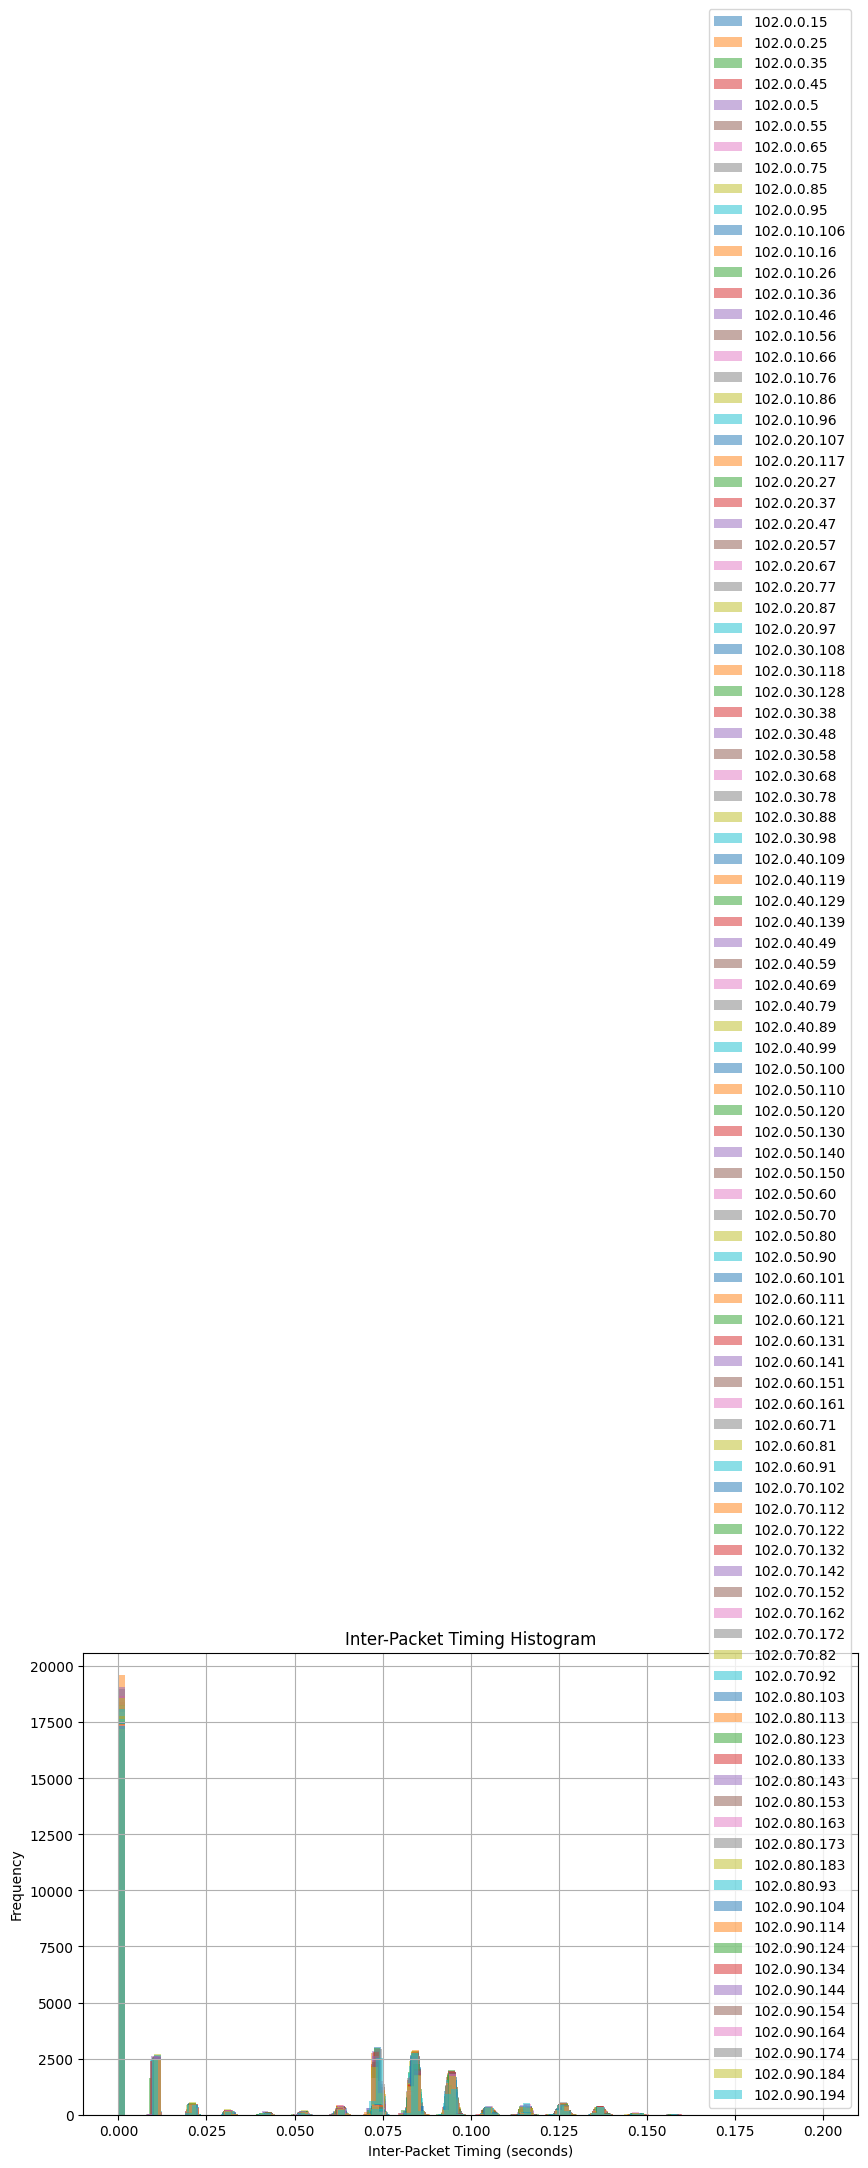

,mean,std
ip.src,,
102.0.0.15,0 days 00:00:00.119150134,0 days 00:00:00.521738844
102.0.0.25,0 days 00:00:00.116016079,0 days 00:00:00.529246258
102.0.0.35,0 days 00:00:00.125315014,0 days 00:00:00.584065905
102.0.0.45,0 days 00:00:00.126518479,0 days 00:00:00.608776387
102.0.0.5,0 days 00:00:00.117856406,0 days 00:00:00.493103672
...,...,...
102.0.90.154,0 days 00:00:00.134478235,0 days 00:00:00.651342530
102.0.90.164,0 days 00:00:00.133272639,0 days 00:00:00.667594296
102.0.90.174,0 days 00:00:00.133750318,0 days 00:00:00.688742100


In [57]:
result = inter_timing(dot_vpn_csv_df)
result

/tmp/ipykernel_3210959/2044584648.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['frame.time'] = pd.to_datetime(df2['frame.time'], format='%b %d, %Y %H:%M:%S.%f EDT')
/tmp/ipykernel_3210959/2044584648.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['inter_packet_timing'] = grouped['frame.time'].diff()


0 days 00:00:00.131184711 0 days 00:00:00.063425298
          ip.src  row_count
0     102.0.0.15      33885
1     102.0.0.25      35180
2     102.0.0.35      32842
3     102.0.0.45      32719
4      102.0.0.5      33934
..           ...        ...
95  102.0.90.154      31492
96  102.0.90.164      31857
97  102.0.90.174      31704
98  102.0.90.184      31803
99  102.0.90.194      31803

[100 rows x 2 columns]


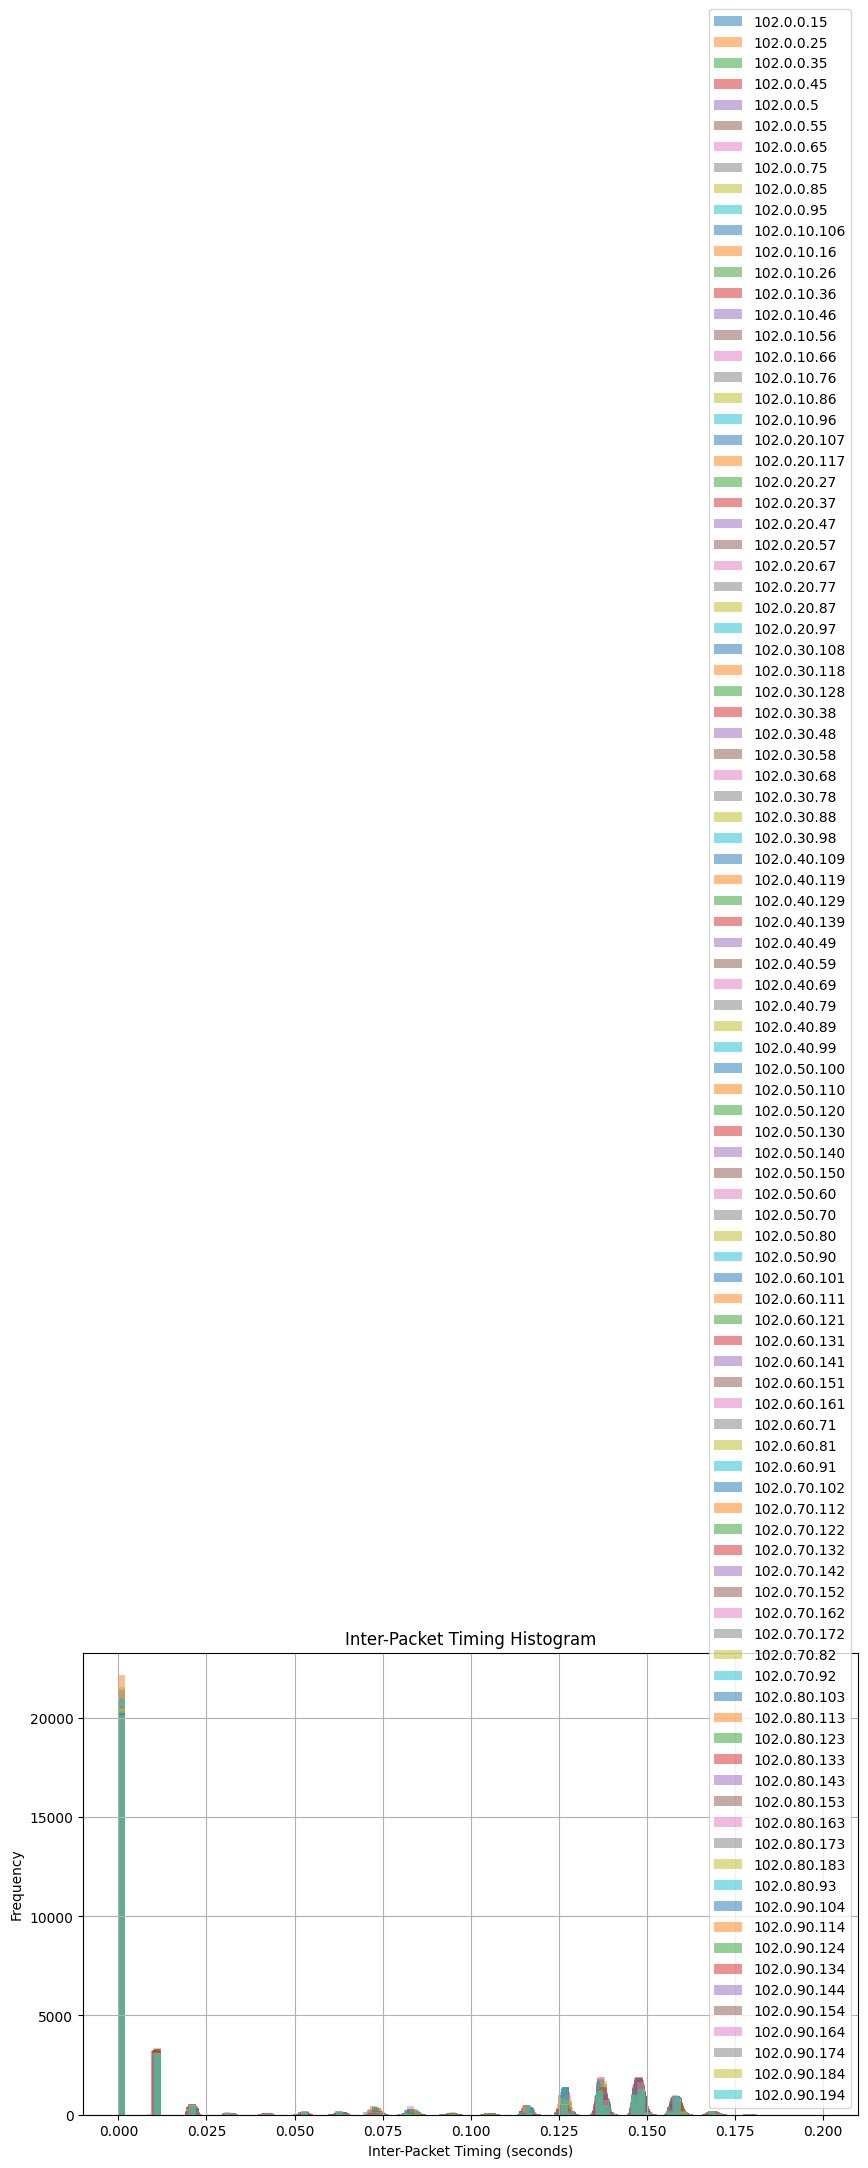

,mean,std
ip.src,,
102.0.0.15,0 days 00:00:00.120305883,0 days 00:00:00.517251295
102.0.0.25,0 days 00:00:00.117109076,0 days 00:00:00.522856656
102.0.0.35,0 days 00:00:00.126517642,0 days 00:00:00.575738157
102.0.0.45,0 days 00:00:00.127946819,0 days 00:00:00.599342259
102.0.0.5,0 days 00:00:00.118950675,0 days 00:00:00.490485183
...,...,...
102.0.90.154,0 days 00:00:00.135193362,0 days 00:00:00.640671435
102.0.90.164,0 days 00:00:00.133956397,0 days 00:00:00.654623932
102.0.90.174,0 days 00:00:00.134596130,0 days 00:00:00.675050794


In [58]:
result = inter_timing(doh_vpn_csv_df)
result